In [18]:
# display plots inline
%matplotlib notebook

# imports
import os
import numpy as np
import pandas as pd
import pymc3 as pm
from bambi import Model, Prior
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import pymc3_utils as pmu

# suppress system warnings for legibility
import warnings
warnings.filterwarnings('ignore')

# resize plots to fit labels inside bounding box
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

# MPI color scheme
sns.set(style='white', palette='Set2')

# Word reading
## Loading data

In [19]:
df_reading = pd.read_csv('data/tamil_reading.tsv', sep='\t')
df_span = pd.read_csv('data/span_intercepts.tsv', sep='\t')[['pp', 'raw_span_mean', 'span_intercept']]
df_ravens = pd.read_csv('data/ravens_intercepts.tsv', sep='\t')[['pp', 'raw_ravens_mean', 'ravens_intercept']]
df_reading = df_reading.merge(df_ravens, left_on='pp', right_on='pp')
df_reading = df_reading.merge(df_span, left_on='pp', right_on='pp')
display(df_reading.head().round(2))

subject     pp literate  word  pseudoword  raw_ravens_mean  \
0        1  low_1      low    24           1             0.28   
1        2    y_2        y    63          42             0.67   
2        3    y_3        y    80          49             0.56   
3        4    y_4        y    47          33             0.39   
4        5    n_5        n     0           0             0.06   

   ravens_intercept  raw_span_mean  span_intercept  
0              0.32            4.5            0.51  
1              1.77            5.0            0.66  
2              1.33            5.5            0.91  
3              0.87            4.5            0.47  
4             -0.72            2.0           -0.60

## Data mangling and plotting

We suspect reading scores are highly correlated with our cognitive ability measures (ravens and digit span). To get a better idea of these relationships, we will draw a heatmap of absolute (rectified) correlations.

word  pseudoword  raw_span_mean  span_intercept  \
word              1.00        0.93           0.51            0.51   
pseudoword        0.93        1.00           0.48            0.48   
raw_span_mean     0.51        0.48           1.00            1.00   
span_intercept    0.51        0.48           1.00            1.00   
raw_ravens_mean   0.53        0.47           0.48            0.47   
ravens_intercept  0.52        0.47           0.47            0.47   

                  raw_ravens_mean  ravens_intercept  
word                         0.53              0.52  
pseudoword                   0.47              0.47  
raw_span_mean                0.48              0.47  
span_intercept               0.47              0.47  
raw_ravens_mean              1.00              0.99  
ravens_intercept             0.99              1.00

<IPython.core.display.Javascript object>


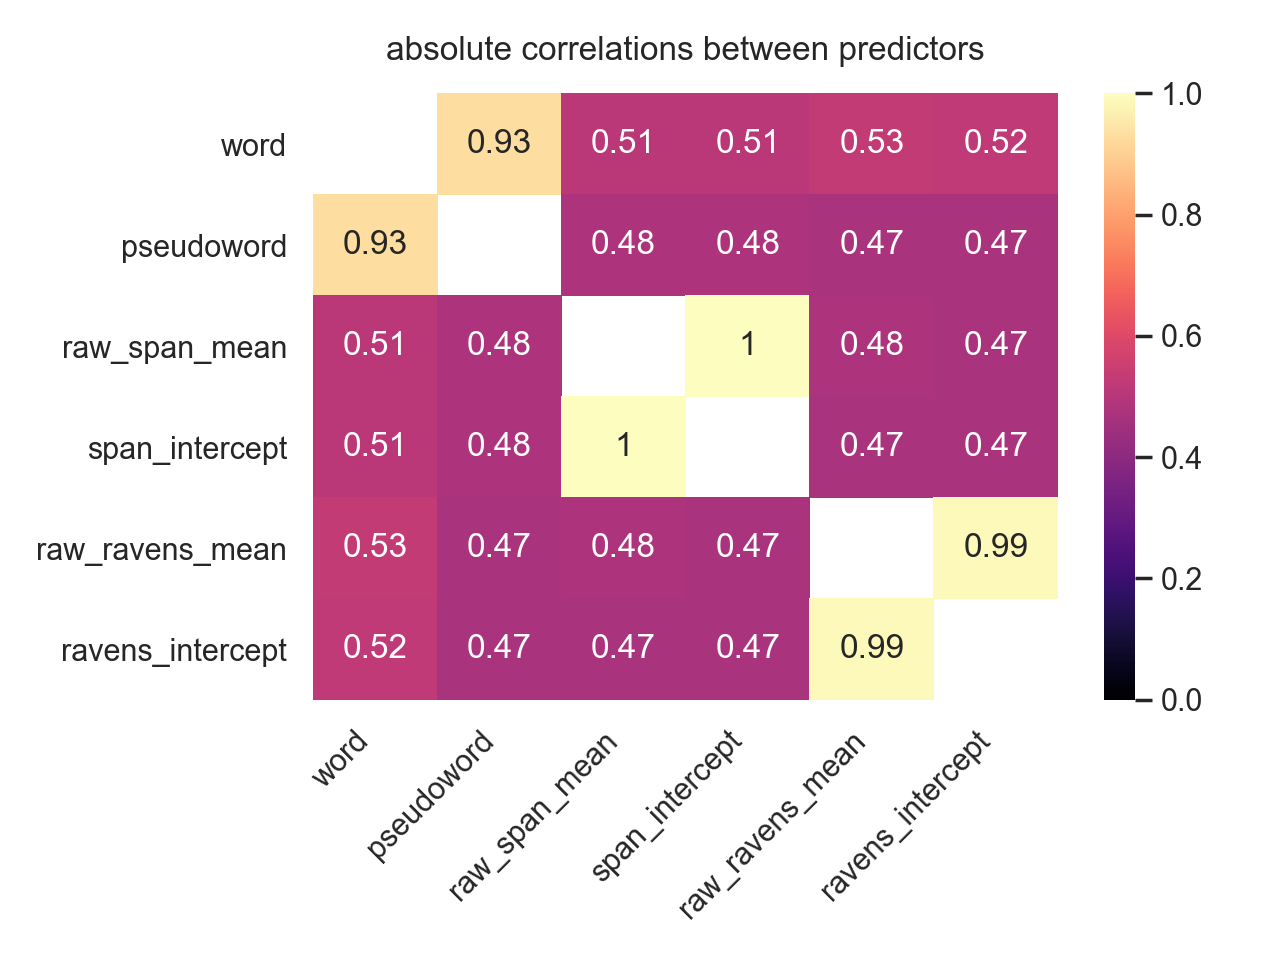

In [20]:
# check correlations
corrs = df_reading[[
    'word', 'pseudoword',
    'raw_span_mean', 'span_intercept',
    'raw_ravens_mean', 'ravens_intercept']].corr().round(2)
display(corrs)
diag = np.eye(*corrs.shape)
diag[diag == 1] = np.nan
corrs = np.abs(corrs + diag)
g = sns.heatmap(corrs, cmap='magma', vmin=0, vmax=1, annot=True)
g.set_xticklabels(
    g.get_xticklabels(),
    rotation=45, ha='right')
g.set_yticklabels(
    g.get_yticklabels(),
    rotation=0)
g.set(ylim=(len(corrs), 0))
g.set_title('absolute correlations between predictors', pad=12)
plt.savefig('figures/precorrection_heatmap.pdf')
plt.savefig('figures/precorrection_heatmap.png', dpi=600, bbox_inches='tight')

If we want to use reading score as a predictor of literacy, independent of cognitive ability (and other relevant factors that were likely unintentionally captured in the cognitive ability scores, such as familiarity with formal test-taking) we will need to correct the reading scores. Our correction procedure consists of regressing out common variance with the cognitive ability measures.

In [21]:
df_reading['literate'] = df_reading['literate'].replace({'y': 'literate', 'low': 'low-literate', 'n': 'illiterate'})
df_reading = pd.melt(df_reading, id_vars=['subject', 'pp', 'literate',
                                          'raw_ravens_mean', 'ravens_intercept',
                                          'raw_span_mean', 'span_intercept'],
                     value_vars=['word', 'pseudoword'], var_name='task', value_name='score')
display(df_reading.head().round(2))

subject     pp      literate  raw_ravens_mean  ravens_intercept  \
0        1  low_1  low-literate             0.28              0.32   
1        2    y_2      literate             0.67              1.77   
2        3    y_3      literate             0.56              1.33   
3        4    y_4      literate             0.39              0.87   
4        5    n_5    illiterate             0.06             -0.72   

   raw_span_mean  span_intercept  task  score  
0            4.5            0.51  word     24  
1            5.0            0.66  word     63  
2            5.5            0.91  word     80  
3            4.5            0.47  word     47  
4            2.0           -0.60  word      0

To confirm that the reading scores is indeed associated with literacy in a meaningful way, we are plotting the distribution of word and pseudoword reading scores in each self-reported literacy group (literate, low-literate, and illiterate).

<IPython.core.display.Javascript object>


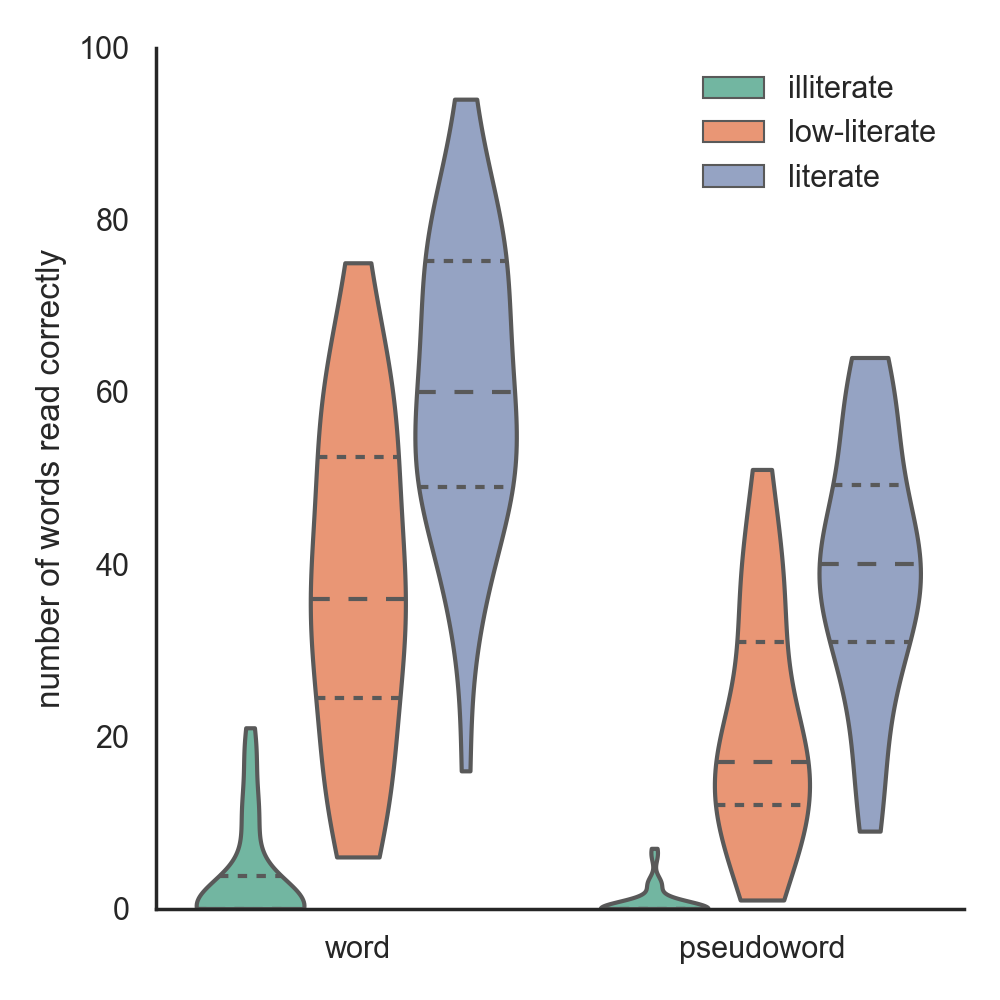

In [22]:
# plot reading score distributions
g = sns.catplot(x='task', y='score', hue='literate',
                hue_order=['illiterate', 'low-literate', 'literate'],
                scale='count', cut=0, inner='quartile',
                kind='violin', data=df_reading, legend=False)
g.set(ylim=(0, 100), xlabel='', ylabel='number of words read correctly')
g.ax.legend(loc='upper right', frameon=False)
plt.savefig('figures/reading_scores.pdf')
plt.savefig('figures/reading_scores.png', dpi=600, bbox_inches='tight')

Self-reported literacy is strongly associated with word reading scores, but there is clearly overlap between the categories (i.e., some participants reported being low-literate, but scored better than other participants that reported being fully literate) which is likely due to participants finding it difficult to estimate their own literacy relative to others. We will therefore use the measured word reading scores as our measure of literacy in the analyses reported below.

In [23]:
# standardize variables
df_reading['task_z'] = pmu.standardize(pd.get_dummies(df_reading['task'])['word'])
df_reading['ravens_z'] = pmu.standardize(df_reading['raw_ravens_mean'])
df_reading['span_z'] = pmu.standardize(df_reading['raw_span_mean'])
display(df_reading.head().round(2))

subject     pp      literate  raw_ravens_mean  ravens_intercept  \
0        1  low_1  low-literate             0.28              0.32   
1        2    y_2      literate             0.67              1.77   
2        3    y_3      literate             0.56              1.33   
3        4    y_4      literate             0.39              0.87   
4        5    n_5    illiterate             0.06             -0.72   

   raw_span_mean  span_intercept  task  score  task_z  ravens_z  span_z  
0            4.5            0.51  word     24     1.0      0.39    0.81  
1            5.0            0.66  word     63     1.0      2.81    1.20  
2            5.5            0.91  word     80     1.0      2.12    1.58  
3            4.5            0.47  word     47     1.0      1.08    0.81  
4            2.0           -0.60  word      0     1.0     -1.00   -1.12

Because word reading scores range from 0 to 100 (with hard boundaries) it would be incorrect to model them using a linear regression model. Instead we are modelling each word in the reading task as a Bernoulli trial, using a generalized linear (i.e., logistic) model. In order to make this possible, we are going to expand each participants' reading score into 100 trials.

In [24]:
# expand binomial dataset to bernoulli trials for modeling
df_bernoulli = pmu.expand_binomial(df_reading, 'score', 100)
display(df_bernoulli.head().round(2))

index  subject     pp      literate  raw_ravens_mean  ravens_intercept  \
0      0        1  low_1  low-literate             0.28              0.32   
1      0        1  low_1  low-literate             0.28              0.32   
2      0        1  low_1  low-literate             0.28              0.32   
3      0        1  low_1  low-literate             0.28              0.32   
4      0        1  low_1  low-literate             0.28              0.32   

   raw_span_mean  span_intercept  task  score  task_z  ravens_z  span_z  \
0            4.5            0.51  word     24     1.0      0.39    0.81   
1            4.5            0.51  word     24     1.0      0.39    0.81   
2            4.5            0.51  word     24     1.0      0.39    0.81   
3            4.5            0.51  word     24     1.0      0.39    0.81   
4            4.5            0.51  word     24     1.0      0.39    0.81   

   score_bernoulli  
0                1  
1                1  
2                1  
3                1  
4                1

## Models

In [25]:
# default model params
defaults = {
    'samples': 5000,
    'tune': 2500,
    'chains': 4,
    'init': 'advi+adapt_diag',
    'family': 'bernoulli',
    'priors': {'fixed': 'narrow', 'random': 'narrow'},
}

We expect a model with task (word versus pseudoword), digit span, and ravens score, plus the interactions between digit span and task, and ravens score and task as predictors to fit best, but we will also compare models with subsets of those predictors to see if a more parsimonious model perhaps has just as good a fit.

In [27]:
fixed_task = Model(df_bernoulli)
fixed_task.fit('score_bernoulli ~ task_z',
               **defaults)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 10,968:  20%|██        | 10164/50000 [00:26<01:43, 385.17it/s]
Convergence achieved at 10200
Interrupted at 10,199 [20%]: Average Loss = 11,439
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [task_z, Intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 30000/30000 [01:12<00:00, 415.85draws/s]


In [28]:
fixed_task_span = Model(df_bernoulli)
fixed_task_span.fit('score_bernoulli ~ task_z + span_z',
                    **defaults)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 10,211:  20%|█▉        | 9892/50000 [00:30<02:03, 325.88it/s]
Convergence achieved at 9900
Interrupted at 9,899 [19%]: Average Loss = 10,968
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [span_z, task_z, Intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 30000/30000 [01:40<00:00, 297.14draws/s]


In [29]:
fixed_task_ravens = Model(df_bernoulli)
fixed_task_ravens.fit('score_bernoulli ~ task_z + ravens_z',
                      **defaults)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 10,323:  20%|██        | 10077/50000 [00:29<01:56, 344.07it/s]
Convergence achieved at 10100
Interrupted at 10,099 [20%]: Average Loss = 11,051
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ravens_z, task_z, Intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 30000/30000 [01:41<00:00, 296.45draws/s]


In [30]:
fixed_task_span_ravens = Model(df_bernoulli)
fixed_task_span_ravens.fit('score_bernoulli ~ task_z + span_z + ravens_z',
                           **defaults)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 10,057:  20%|█▉        | 9870/50000 [00:29<02:00, 333.67it/s]
Convergence achieved at 9900
Interrupted at 9,899 [19%]: Average Loss = 10,984
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ravens_z, span_z, task_z, Intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 30000/30000 [01:59<00:00, 252.10draws/s]


In [31]:
fixed_taskxspanxravens = Model(df_bernoulli)
fixed_taskxspanxravens.fit('score_bernoulli ~ task_z*span_z + task_z*ravens_z',
                           **defaults)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 9,932.7:  43%|████▎     | 21372/50000 [01:12<01:36, 296.78it/s]
Convergence achieved at 21400
Interrupted at 21,399 [42%]: Average Loss = 10,616
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [task_z:ravens_z, ravens_z, task_z:span_z, span_z, task_z, Intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 30000/30000 [02:48<00:00, 177.65draws/s]


## Model comparison of fixed-effects models

<IPython.core.display.Javascript object>


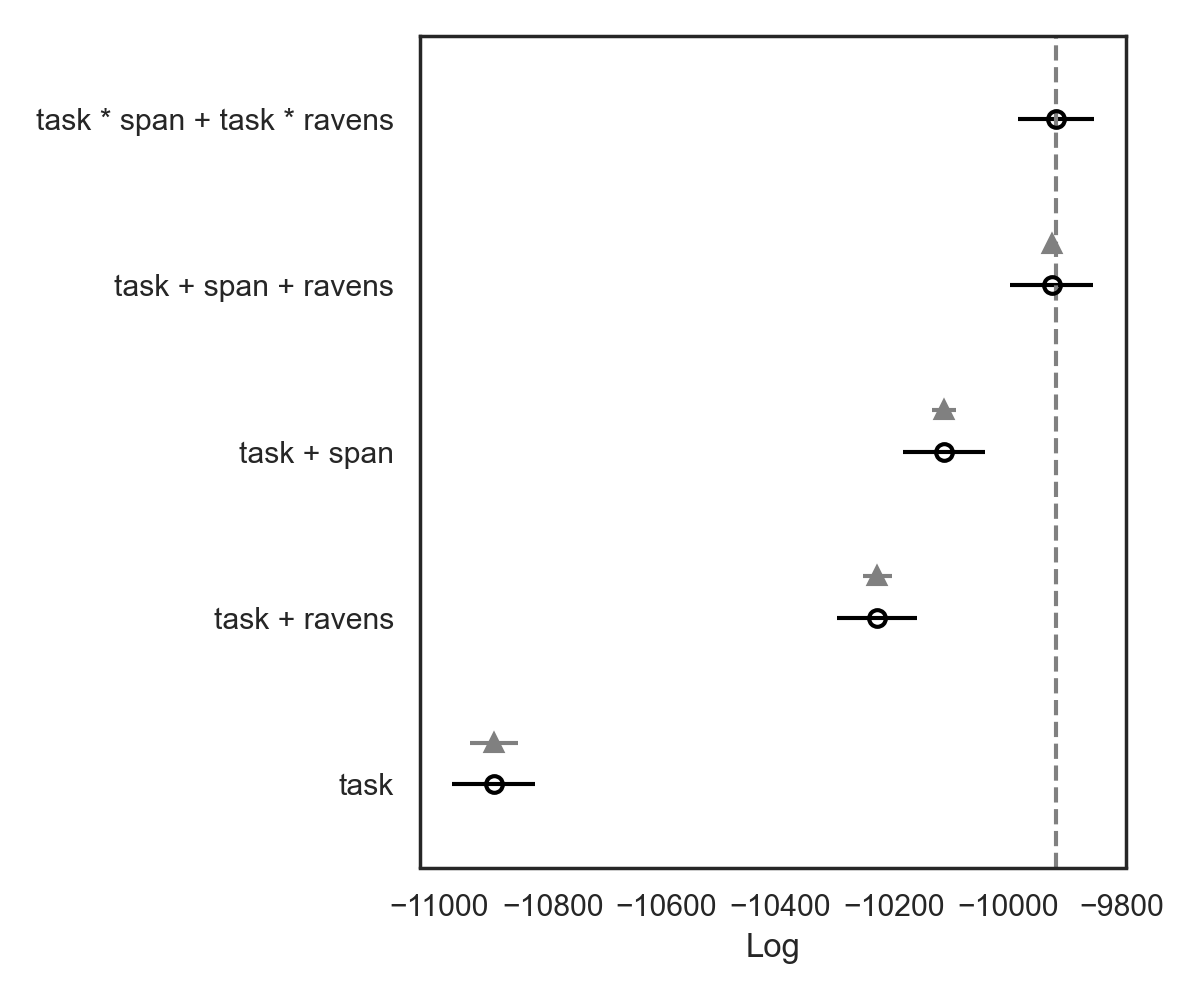

rank      loo    p_loo    d_loo weight       se  \
task * span + task * ravens    0 -9914.87  6.38393        0    NaN  66.5539   
task + span + ravens           1 -9922.79  4.18062  7.91744    NaN  72.6608   
task + span                    2 -10111.9   3.2425  197.059    NaN  72.2265   
task + ravens                  3   -10230  3.09232  315.086    NaN  70.8491   
task                           4 -10903.9  2.01904  989.025      0  72.4457   

                                 dse warning loo_scale  
task * span + task * ravens        0   False       log  
task + span + ravens         4.49157   False       log  
task + span                  20.8978   False       log  
task + ravens                 25.512   False       log  
task                         42.4881   False       log

In [35]:
from importlib import reload
reload(pmu)
g_comparison, comparison = pmu.compare({
    'task': fixed_task,
    'task + span': fixed_task_span,
    'task + ravens': fixed_task_ravens,
    'task + span + ravens': fixed_task_span_ravens,
    'task * span + task * ravens': fixed_taskxspanxravens,
}, ic='LOO')
display(comparison)
plt.savefig('figures/reading_model_comparison.pdf')
plt.savefig('figures/reading_model_comparison.png', dpi=600, bbox_inches='tight')

As expected, the most complex model fits best, but interestingly, the `reading_score ~ task + span + ravens` model without interactions fits just as well (after correcting for model complexity) meaning that there is no meaningful interaction between task and the other two predictors. We will now refit this nicely parsimonious model with by-participant intercepts in order to be able to use these intercepts as corrected reading scores in our recognition memory models.

## Best fit fixed effects model with random intercepts by participant

In [ ]:
mixed_taskxspanxravens = Model(df_bernoulli)
mixed_taskxspanxravens.fit('score_bernoulli ~ task_z*span_z + task_z*ravens_z',
                      random=['1|pp'],
                      **defaults)

In [45]:
display(pm.summary(mixed_taskxspanxravens.backend.trace, credible_interval=.95).round(2))

mean    sd  hpd_2.5%  hpd_97.5%  mcse_mean  mcse_sd  \
Intercept[0]     -2.13  0.22     -2.57      -1.71       0.01     0.00   
task_z[0]         0.47  0.02      0.43       0.52       0.00     0.00   
span_z[0]         0.87  0.22      0.44       1.31       0.01     0.00   
task_z:span_z[0]  0.01  0.03     -0.04       0.06       0.00     0.00   
ravens_z[0]       0.67  0.21      0.26       1.07       0.00     0.00   
...                ...   ...       ...        ...        ...      ...   
1|pp[91]          1.56  0.27      1.01       2.09       0.01     0.00   
1|pp[92]          2.02  0.31      1.41       2.63       0.01     0.01   
1|pp[93]          1.43  0.42      0.64       2.26       0.01     0.01   
1|pp[94]          0.93  0.30      0.34       1.52       0.01     0.01   
1|pp[95]          1.68  0.26      1.18       2.20       0.01     0.00   

                  ess_mean   ess_sd  ess_bulk  ess_tail  r_hat  
Intercept[0]        1034.0   1034.0    1029.0    2038.0    1.0  
task_z[0]          18251.0  18251.0   18242.0   15106.0    1.0  
span_z[0]           1399.0   1381.0    1403.0    2585.0    1.0  
task_z:span_z[0]   15753.0  12639.0   15755.0   15241.0    1.0  
ravens_z[0]         1513.0   1482.0    1512.0    2951.0    1.0  
...                    ...      ...       ...       ...    ...  
1|pp[91]            1379.0   1379.0    1378.0    3138.0    1.0  
1|pp[92]            1320.0   1320.0    1318.0    3159.0    1.0  
1|pp[93]            1519.0   1519.0    1517.0    3577.0    1.0  
1|pp[94]            1327.0   1327.0    1326.0    3020.0    1.0  
1|pp[95]            1482.0   1482.0    1480.0    3744.0    1.0  

[199 rows x 11 columns]

NUTS warns that the number of effective samples is smaller than 10% for some parameters. This can be an indicator of several sampling issues, most likely mild autocorrelation. The sampling stats still show more than 1.5K effective samples for all parameters and \\(\hat{r}\\) values also look good.  
We will plot model traces below to look at the autocorrelation issue.

## Plotting model traces

<IPython.core.display.Javascript object>


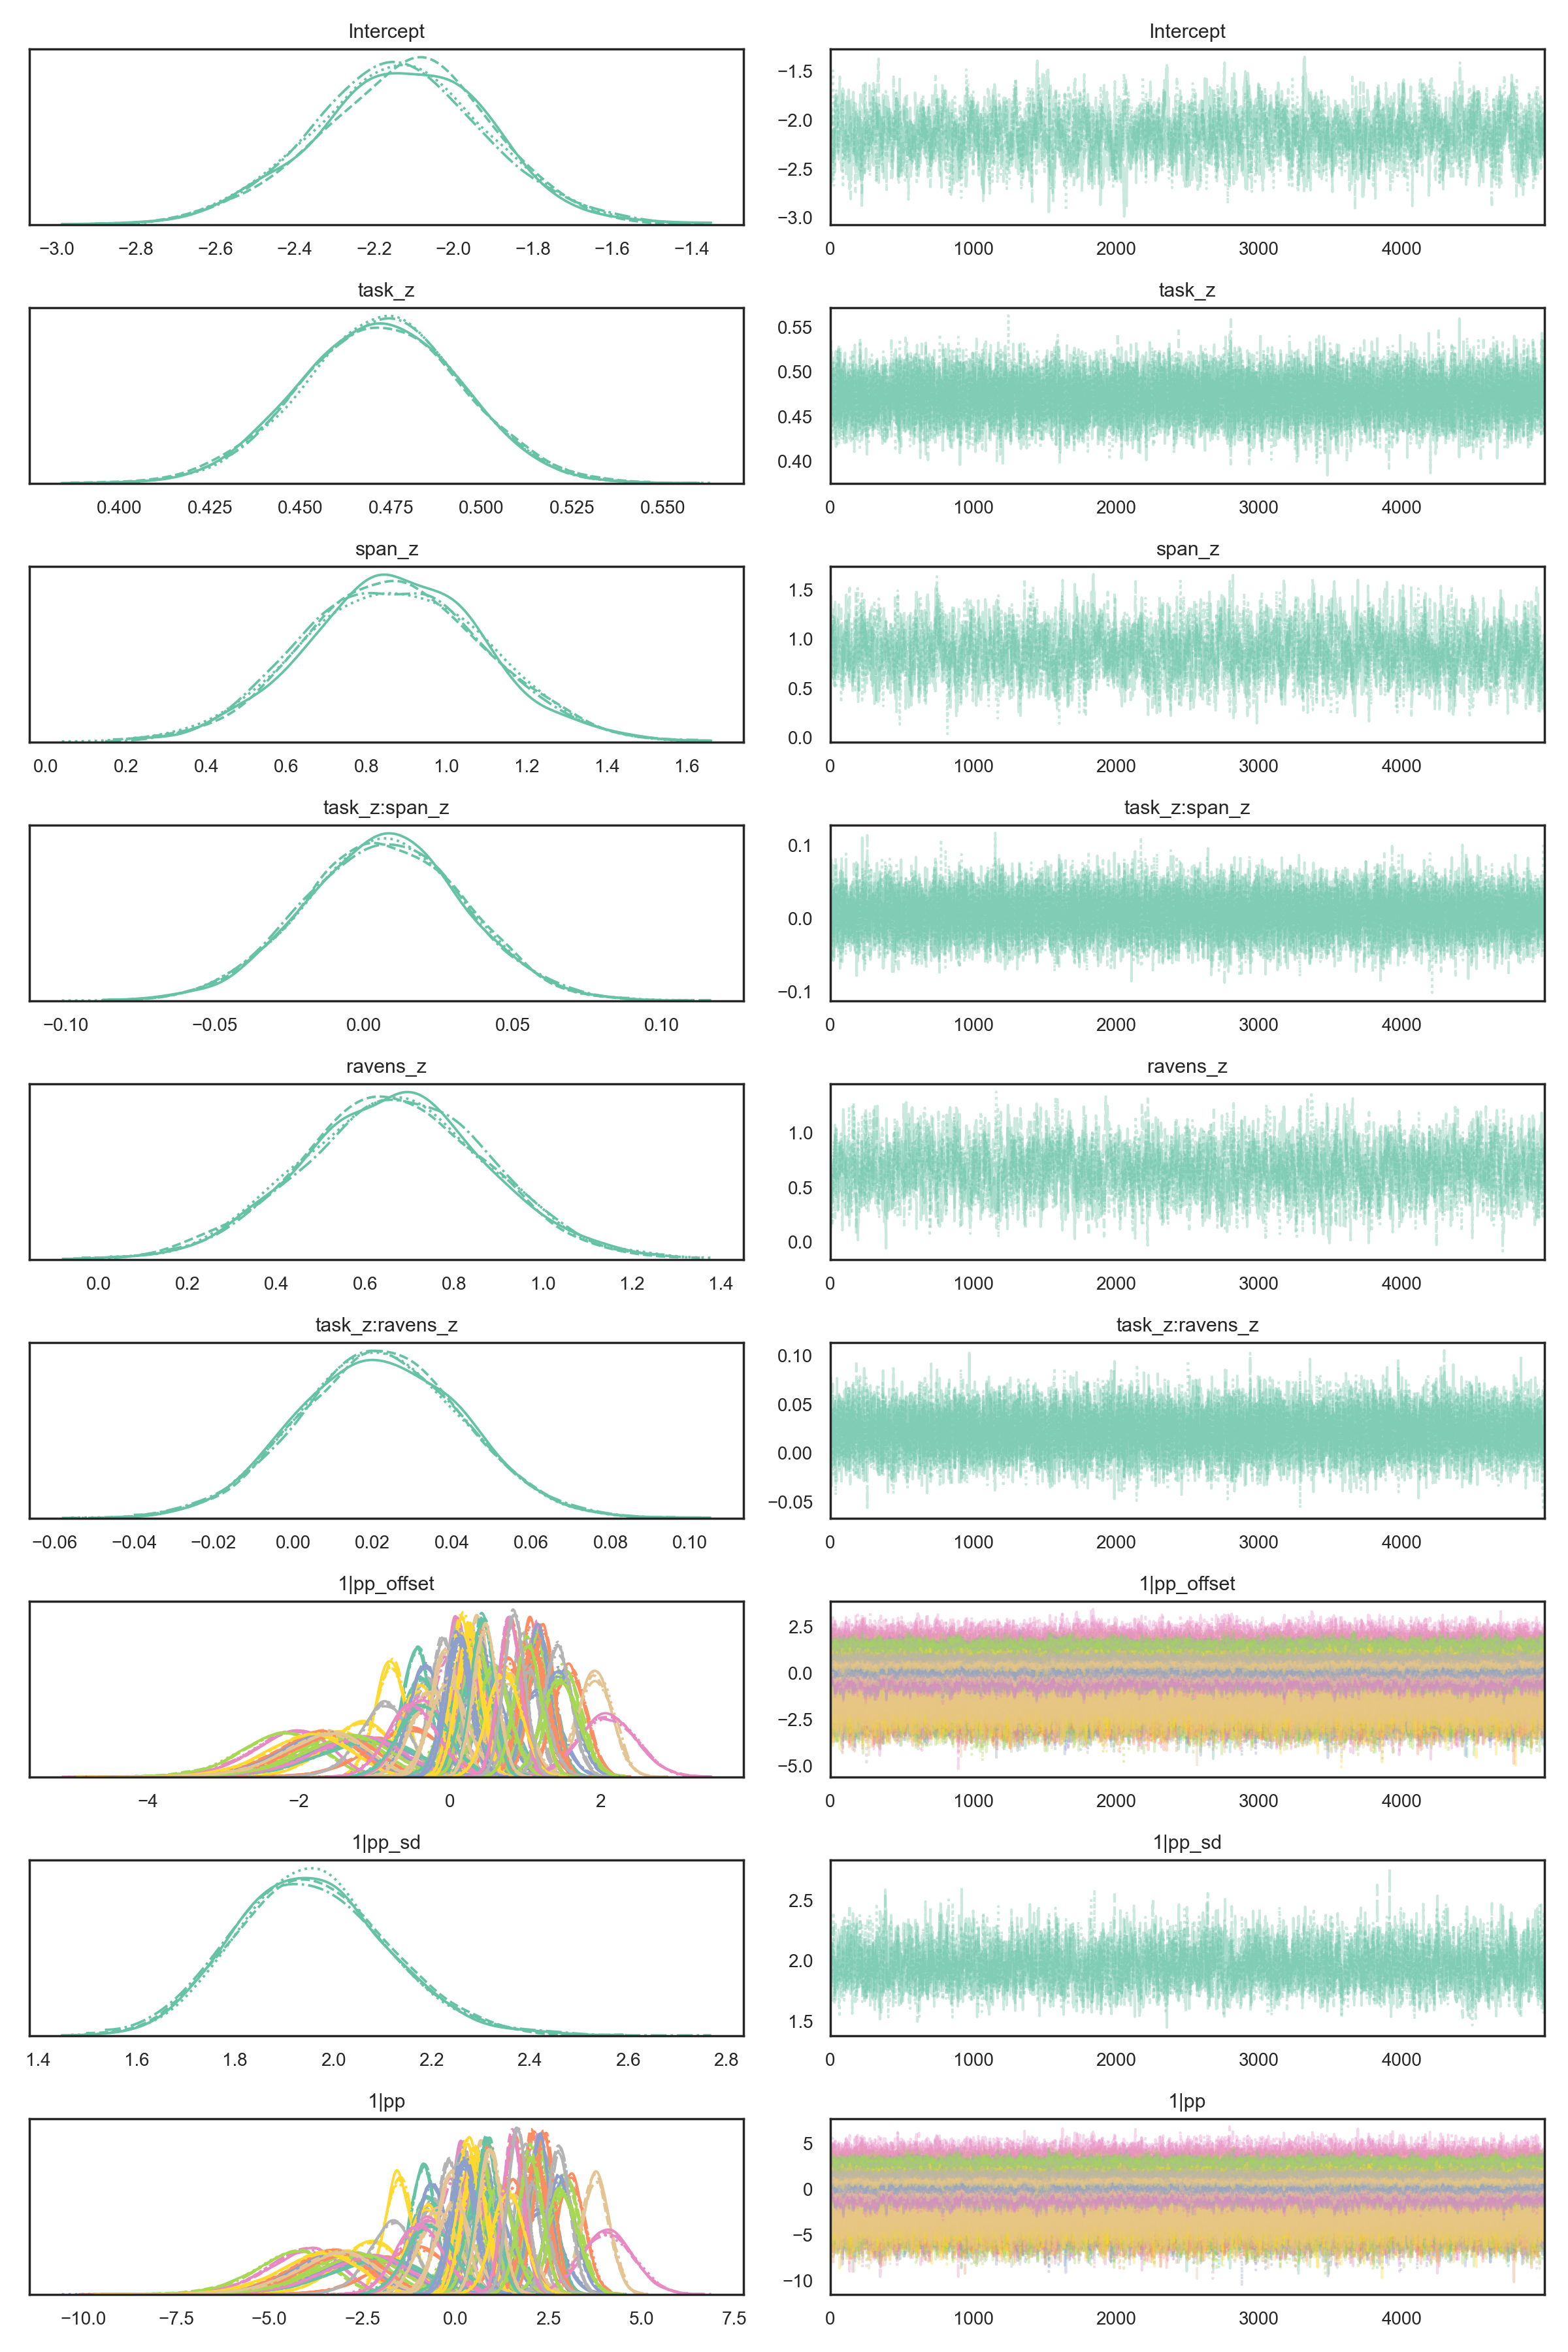

In [58]:
g_traces = pm.traceplot(mixed_taskxspanxravens.backend.trace)
plt.savefig('figures/reading_model_traces.png', dpi=600)

The posterior traces (right column) show signs of very mild autocorrelation, but nothing pathological. (We appear to be exploring the parameter space fairly well.)  
Posterior densities (left column) also look well-behaved (i.e. unimodal, roughly normally distributed).

In [46]:
pps = df_reading['pp'].unique()
pp_nums = [f'1|pp[{i}]' for i in range(len(pps))]
df_intercepts = pm.summary(mixed_taskxspanxravens.backend.trace).loc[pp_nums]
df_intercepts['pp'] = np.sort(pps)

display(df_intercepts.head().round(2))

mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
1|pp[0] -0.87  0.34   -1.51    -0.24       0.01     0.01    1627.0  1627.0   
1|pp[1]  2.10  0.27    1.58     2.60       0.01     0.00    1432.0  1432.0   
1|pp[2]  0.62  0.31    0.04     1.22       0.01     0.01    1298.0  1298.0   
1|pp[3]  0.19  0.28   -0.33     0.74       0.01     0.00    1494.0  1494.0   
1|pp[4]  0.28  0.44   -0.57     1.09       0.01     0.01    1319.0  1319.0   

         ess_bulk  ess_tail  r_hat      pp  
1|pp[0]    1627.0    3904.0    1.0   low_1  
1|pp[1]    1430.0    3418.0    1.0  low_10  
1|pp[2]    1296.0    3077.0    1.0  low_11  
1|pp[3]    1494.0    3755.0    1.0  low_12  
1|pp[4]    1320.0    3454.0    1.0  low_13

In [19]:
df_uncorrected = df_reading.groupby('pp', as_index=False).mean().rename(columns={'score': 'raw_reading_score'})
df_intercepts = df_intercepts[['pp', 'mean']].rename(columns={'mean': 'adjusted_reading_score'})
df_intercepts = df_intercepts.merge(df_uncorrected,
                                    left_on='pp', right_on='pp').reset_index()

display(df_intercepts.head().round(2))

index      pp  adjusted_reading_score  subject  raw_ravens_mean  \
0      0   low_1                   -0.84      1.0             0.28   
1      1  low_10                    2.08     40.0             0.17   
2      2  low_11                    0.66     41.0             0.22   
3      3  low_12                    0.21     42.0             0.28   
4      4  low_13                    0.29     43.0             0.11   

   ravens_intercept  raw_span_mean  span_intercept  raw_reading_score  task_z  \
0              0.32            4.5            0.51               12.5     0.0   
1             -0.13            3.5            0.00               45.5     0.0   
2              0.16            4.5            0.49               32.5     0.0   
3              0.40            4.0            0.29               22.5     0.0   
4             -0.50            5.0            0.70               23.5     0.0   

   ravens_z  span_z  
0      0.39    0.81  
1     -0.31    0.04  
2      0.04    0.81  
3      0.39    0.43  
4     -0.65    1.20

In [20]:
# write intercepts to file
df_intercepts.to_csv('data/reading_intercepts.tsv', sep='\t')

To make sure our score correction had the desired effect, we plot a heatmap of absolute correlations between the cognitive ability measures and both the corrected and uncorrected reading scores.

raw_reading_score  raw_span_mean  raw_ravens_mean  \
raw_reading_score                    1.00           0.51             0.51   
raw_span_mean                        0.51           1.00             0.48   
raw_ravens_mean                      0.51           0.48             1.00   
adjusted_reading_score               0.72           0.02             0.03   

                        adjusted_reading_score  
raw_reading_score                         0.72  
raw_span_mean                             0.02  
raw_ravens_mean                           0.03  
adjusted_reading_score                    1.00

<IPython.core.display.Javascript object>


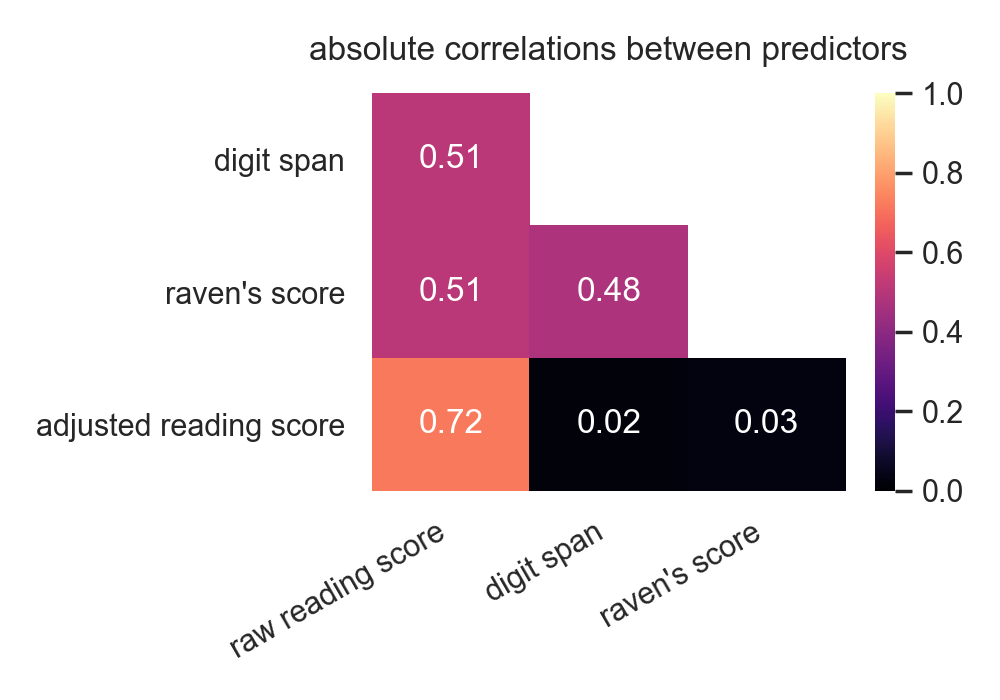

In [20]:
# check correlations
corrs = df_intercepts[[
    'raw_reading_score',
    'raw_span_mean',
    'raw_ravens_mean',
    'adjusted_reading_score',
]].corr().round(2)
display(corrs)
upper = np.triu(np.ones(corrs.shape))
upper[upper == 1] = np.nan
corrs = np.abs(corrs + upper)
plt.figure(figsize=(5, 3.5))
g = sns.heatmap(corrs, cmap='magma', vmin=0, vmax=1, annot=True)
labels = [
    'raw reading score',
    'digit span',
    'raven\'s score',
    'adjusted reading score',
]
g.set_xticklabels(
    labels,
    rotation=30, ha='right')
g.set_yticklabels(
    labels,
    rotation=0)
g.set(ylim=(len(corrs), 1), xlim=(0, len(corrs) - 1))
g.set_title('absolute correlations between predictors', pad=12)
plt.savefig('figures/postcorrection_heatmap.pdf')
plt.savefig('figures/postcorrection_heatmap.png', dpi=600, bbox_inches='tight')

Correlation between unadjusted reading and both cognitive ability measures was .51, after correction the correlation has been reduced to less than .05, while unadjusted and adjusted reading score still share around 50% of their variance (r = .71).

## Reading score adjusted for only Raven's Progressive Matrices
An anonymous reviewer asked whether correcting reading score only for Raven's Progressive Matrices score (and not for digit span) would result in a different coefficient estimate for adjusted reading score in the recognition memory model. To answer the reviewer's question, we repeat the adjustment procedure with Raven's score, but without digit span score.

In [7]:
mixed_task_ravens = Model(df_bernoulli)
mixed_task_ravens.fit('score_bernoulli ~ task_z*ravens_z',
                      random=['1|pp'],
                      **defaults)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 7,946.3:  50%|████▉     | 24996/50000 [01:20<01:20, 309.33it/s]
Convergence achieved at 25000
Interrupted at 24,999 [49%]: Average Loss = 8,833.6
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [1|pp_offset, 1|pp_sd, task_z:ravens_z, ravens_z, task_z, Intercept]
Sampling 4 chains, 0 divergences: 100%|██████████| 30000/30000 [12:50<00:00, 38.92draws/s]
The acceptance probability does not match the target. It is 0.8823658778355581, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


In [16]:
pps = df_reading['pp'].unique()
pp_nums = [f'1|pp[{i}]' for i in range(len(pps))]

df_intercepts = pm.summary(mixed_task_ravens.backend.trace).loc[pp_nums]
df_intercepts['pp'] = np.sort(pps)

display(df_intercepts.head().round(2))

mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
1|pp[0] -0.28  0.32   -0.88     0.31       0.01     0.01     973.0   973.0   
1|pp[1]  2.22  0.27    1.70     2.73       0.01     0.01     645.0   645.0   
1|pp[2]  1.31  0.27    0.79     1.81       0.01     0.01     698.0   698.0   
1|pp[3]  0.45  0.29   -0.08     1.01       0.01     0.01     829.0   829.0   
1|pp[4]  1.51  0.31    0.91     2.08       0.01     0.01     673.0   673.0   

         ess_bulk  ess_tail  r_hat      pp  
1|pp[0]     972.0    2855.0    1.0   low_1  
1|pp[1]     644.0    1766.0    1.0  low_10  
1|pp[2]     698.0    1940.0    1.0  low_11  
1|pp[3]     829.0    2398.0    1.0  low_12  
1|pp[4]     673.0    1922.0    1.0  low_13

In [14]:
df_uncorrected = df_reading.groupby('pp', as_index=False).mean().rename(columns={'score': 'raw_reading_score'})
df_intercepts = df_intercepts[['pp', 'mean']].rename(columns={'mean': 'adjusted_reading_score'})
df_intercepts = df_intercepts.merge(df_uncorrected,
                                    left_on='pp', right_on='pp').reset_index()

display(df_intercepts.head().round(2))

index      pp  adjusted_reading_score  subject  raw_ravens_mean  \
0      0   low_1                   -0.28      1.0             0.28   
1      1  low_10                    2.22     40.0             0.17   
2      2  low_11                    1.31     41.0             0.22   
3      3  low_12                    0.45     42.0             0.28   
4      4  low_13                    1.51     43.0             0.11   

   ravens_intercept  raw_span_mean  span_intercept  raw_reading_score  task_z  \
0              0.32            4.5            0.51               12.5     0.0   
1             -0.13            3.5            0.00               45.5     0.0   
2              0.16            4.5            0.49               32.5     0.0   
3              0.40            4.0            0.29               22.5     0.0   
4             -0.50            5.0            0.70               23.5     0.0   

   ravens_z  span_z  
0      0.39    0.81  
1     -0.31    0.04  
2      0.04    0.81  
3      0.39    0.43  
4     -0.65    1.20

In [15]:
# write intercepts to file
df_intercepts.to_csv('data/reading_intercepts_adjusted_for_only_ravens.tsv', sep='\t')